# EQS GB Cross-Validation for Simple sources

Using cross-validation to determine the best damping and depth for the model.

In [1]:
import numpy as np
import verde as vd
import matplotlib.pyplot as plt
import eqs_magnetics as eqs
from itertools import product

Set the data coordinates and field direction.

In [2]:
region = [-10e3, 10e3, -10e3, 10e3]
coordinates = vd.scatter_points(region, size=15000, random_state=0, extra_coords=500)
field_direction = eqs.angles_to_vector(inclination=84, declination=122, amplitude=1)
#field_direction = eqs.angles_to_vector(inclination=14, declination=122, amplitude=1)
print("N data:", coordinates[0].size)

N data: 15000


Create the dipole source model.

In [3]:
source_inc, source_dec = 45, 45
#source_inc, source_dec = 15, 45
dipole_moments = []
source_coordinates = []

# Dike NE-SW
dike_moment_magnitude = 10e7
source_coordinates.append(vd.profile_coordinates((-20e3, -5e3), (20e3, 12e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# Dike NW-SE
source_coordinates.append(vd.profile_coordinates((20e3, -10e3), (-20e3, 25e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# Dike small
source_coordinates.append(vd.profile_coordinates((20e3, -4e3), (4e3, 3e3), size=1000, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(1000, dike_moment_magnitude)))

# # Dike very small
source_coordinates.append(vd.profile_coordinates((3e3, 3.5e3), (-0.5e3, 5.5e3), size=100, extra_coords=0)[0])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(100, dike_moment_magnitude)))

# point source top left
source_coordinates.append([[-7500], [7000], [-350]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 1e10))

# point source centre
source_coordinates.append([[0], [-100], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 5e10))

# point source bottom right
source_coordinates.append([[7500], [-7500], [-500]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 2e10))

# point source bottom left
source_coordinates.append([[-8000], [-6000], [-800]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, 5e10))

# regional
source_coordinates.append([[2e3, -5e3], [-9e3, 5e3], [-8e3, -8e3]])
dipole_moments.append(eqs.angles_to_vector(source_inc, source_dec, np.full(2, 1e13)))

source_coordinates = np.concatenate(source_coordinates, axis=1)
dipole_moments = np.concatenate(dipole_moments, axis=1)
dipole_moments.shape, source_coordinates.shape

((3, 3106), (3, 3106))

In [4]:
magnetic_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)

In [5]:
total_field_anomaly = eqs.total_field_anomaly(magnetic_field, field_direction)
bnorm = eqs.magnetic_field_norm(magnetic_field)

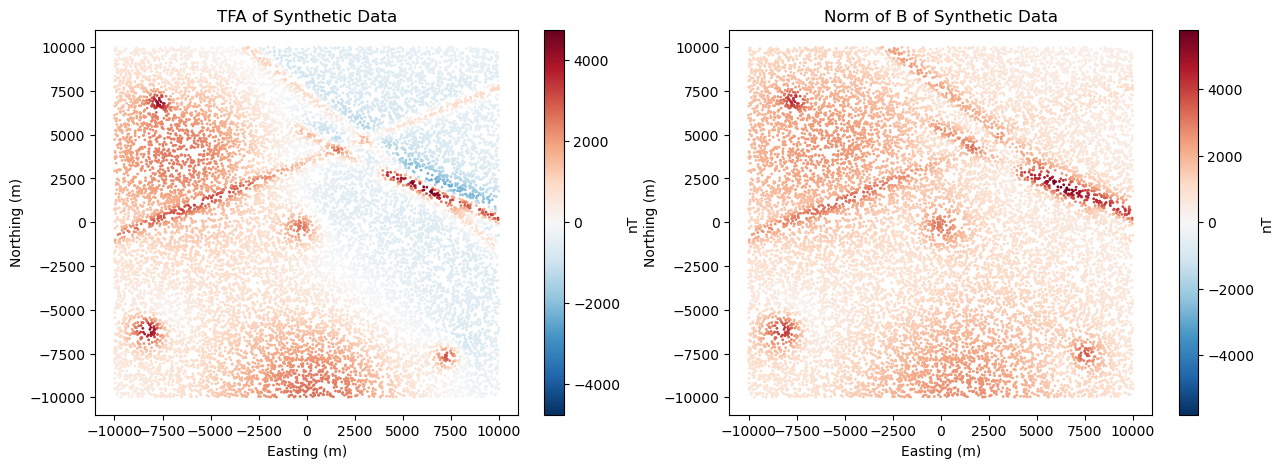

In [6]:
plt.figure(figsize=(15,5))
scale = vd.maxabs(total_field_anomaly)
#scale = 1000
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=total_field_anomaly, cmap="RdBu_r",s=1, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="RdBu_r",s=1, vmin=-scale_bnorm, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit deep sources

Block reduce the data has several advantages:

1. Less data to fit so much faster.
2. The block median reduces the wavelengths in the data, which captures the regional field and leaves the residuals alone.

In [7]:
reducer = vd.BlockReduce(reduction=np.median, spacing=2e3, drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=total_field_anomaly)

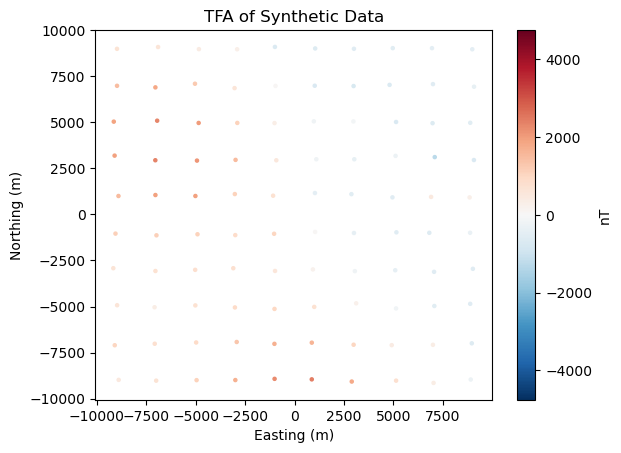

In [8]:
plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_blocked, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

In [9]:
eqs_deep = eqs.EquivalentSourcesMagnetic(damping=1e-5)
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -7577.809515269439


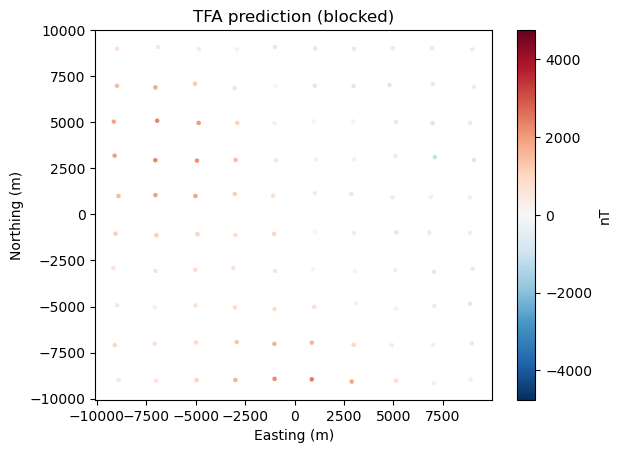

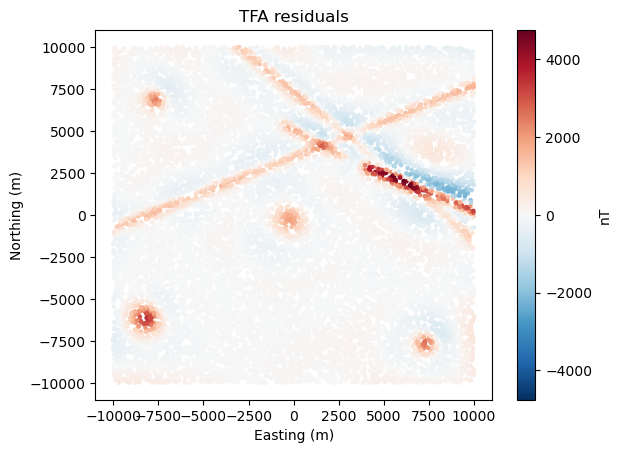

In [10]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = total_field_anomaly - tfa_deep

plt.figure()
plt.scatter(*coords_blocked[:2], c=tfa_deep_blocked, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA prediction (blocked)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.figure()
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

## Fit the shallow residuals with gradient-boosted sources

In [11]:
eqs_shallow = eqs.EquivalentSourcesMagneticGB(damping=1e1, depth=500, random_state=0, block_size=100)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

/home/leo/bin/conda/envs/eqs-gb-norm-of-b/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/leo/bin/conda/envs/eqs-gb-norm-of-b/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/leo/bin/conda/envs/eqs-gb-norm-of-b/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/leo/bin/conda/envs/eqs-gb-norm-of-b/lib/python3.10/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


dipole height: 0.0
window size: 11544.29486148111


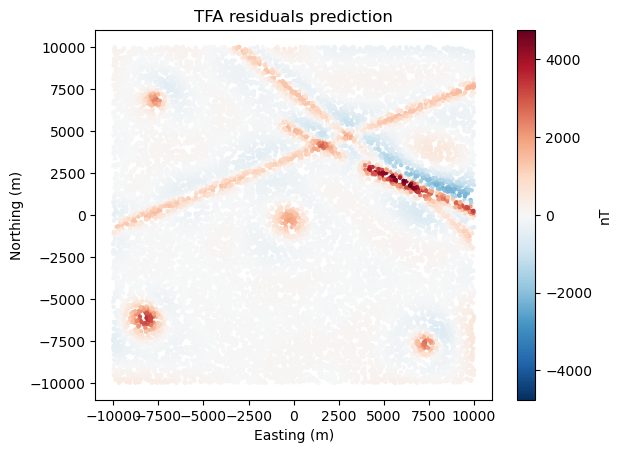

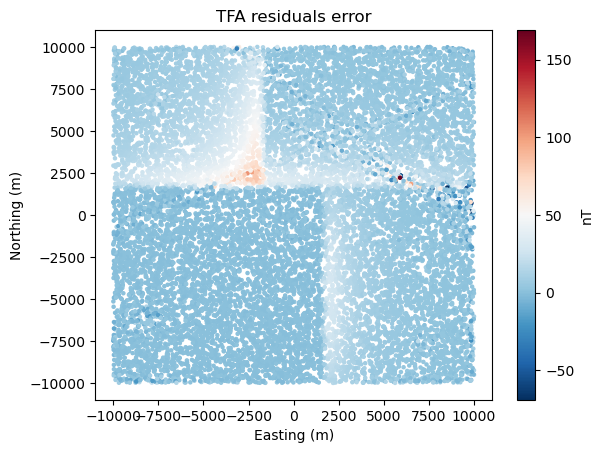

In [12]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure()
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="RdBu_r", s=5, vmin=-scale, vmax=scale)
plt.title("TFA residuals prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.figure()
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="RdBu_r", s=5)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

## Predict the norm of B

In [13]:
grid_coordinates = vd.grid_coordinates(region, spacing=100, extra_coords=500)
true_norm_of_b = np.sqrt(sum(c**2 for c in eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)))
error = true_norm_of_b - predicted_norm_of_b

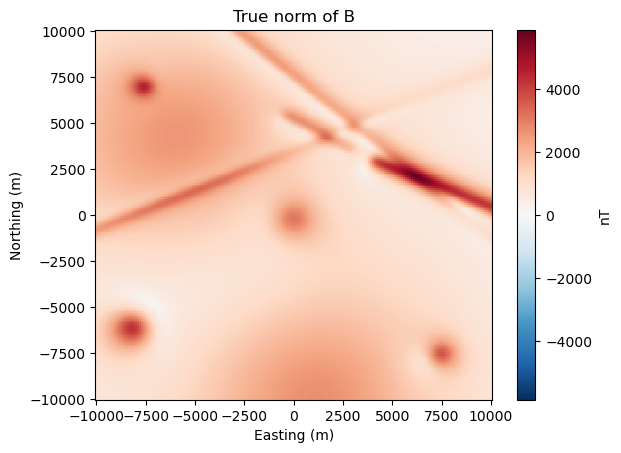

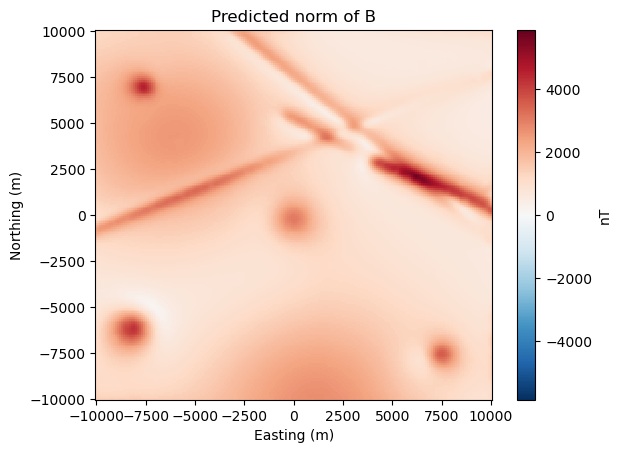

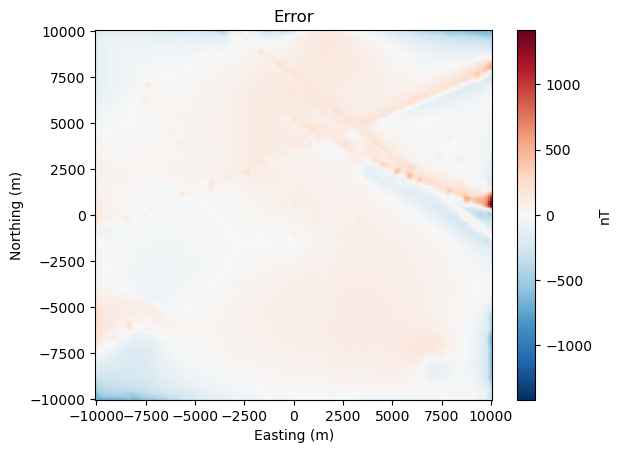

In [14]:
scale_b = vd.maxabs(true_norm_of_b)
plt.figure()
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="RdBu_r", vmin=-scale_b, vmax=scale_b)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.figure()
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="RdBu_r", vmin=-scale_b, vmax=scale_b)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.figure()
diff_scale = vd.maxabs(error)
plt.pcolormesh(*grid_coordinates[:2], error, cmap="RdBu_r", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")